# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1110s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1437, 32, 20, 3)
(1437, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
360/360 [==============================] - 6s 9ms/step - loss: 2.1563 - accuracy: 0.3266
Epoch 2/500
360/360 [==============================] - 3s 8ms/step - loss: 1.2267 - accuracy: 0.6153
Epoch 3/500
360/360 [==============================] - 3s 9ms/step - loss: 0.9731 - accuracy: 0.6967
Epoch 4/500
360/360 [==============================] - 3s 8ms/step - loss: 0.7301 - accuracy: 0.7819
Epoch 5/500
360/360 [==============================] - 3s 8ms/step - loss: 0.7048 - accuracy: 0.7643: 0s - l
Epoch 6/500
360/360 [==============================] - 3s 8ms/step - loss: 0.5595 - accuracy: 0.8287
Epoch 7/500
360/360 [==============================] - 3s 9ms/step - loss: 0.5586 - accuracy: 0.8127
Epoch 8/500
360/360 [==============================] - 3s 9ms/step - loss: 0.4469 - accuracy: 0.8547
Epoch 9/500
360/360 [==============================] - 4s 11ms/step - loss: 0.4601 - accuracy: 0.8646
Epoch 10/500
360/360 [==============================] - 4s 10ms/step - loss: 0.369

360/360 [==============================] - 4s 11ms/step - loss: 0.0816 - accuracy: 0.9761
Epoch 81/500
360/360 [==============================] - 4s 12ms/step - loss: 0.1160 - accuracy: 0.9670
Epoch 82/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1057 - accuracy: 0.9713
Epoch 83/500
360/360 [==============================] - 4s 11ms/step - loss: 0.1063 - accuracy: 0.9672
Epoch 84/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1121 - accuracy: 0.9807
Epoch 85/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0761 - accuracy: 0.9732
Epoch 86/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0689 - accuracy: 0.9789
Epoch 87/500
360/360 [==============================] - 4s 10ms/step - loss: 0.1146 - accuracy: 0.9728
Epoch 88/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0818 - accuracy: 0.9705
Epoch 89/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0877 - 

360/360 [==============================] - 5s 13ms/step - loss: 0.0548 - accuracy: 0.9841
Epoch 158/500
360/360 [==============================] - 4s 12ms/step - loss: 0.0809 - accuracy: 0.9864
Epoch 159/500
360/360 [==============================] - 4s 12ms/step - loss: 0.0449 - accuracy: 0.9891
Epoch 160/500
360/360 [==============================] - 5s 13ms/step - loss: 0.0182 - accuracy: 0.9896
Epoch 161/500
360/360 [==============================] - 4s 12ms/step - loss: 0.0420 - accuracy: 0.9906
Epoch 162/500
360/360 [==============================] - 4s 12ms/step - loss: 0.0702 - accuracy: 0.9797
Epoch 163/500
360/360 [==============================] - 4s 12ms/step - loss: 0.1009 - accuracy: 0.9796
Epoch 164/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.9869
Epoch 165/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0468 - accuracy: 0.9869
Epoch 166/500
360/360 [==============================] - 3s 10ms/step - loss: 

360/360 [==============================] - 4s 11ms/step - loss: 0.0550 - accuracy: 0.9871
Epoch 235/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0401 - accuracy: 0.9890
Epoch 236/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0424 - accuracy: 0.9866
Epoch 237/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0260 - accuracy: 0.9925
Epoch 238/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0406 - accuracy: 0.9859
Epoch 239/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0330 - accuracy: 0.9933 0s - loss: 0.0330 - accuracy: 0.99
Epoch 240/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0326 - accuracy: 0.9904
Epoch 241/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0293 - accuracy: 0.9939
Epoch 242/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0636 - accuracy: 0.9850
Epoch 243/500
360/360 [====================

360/360 [==============================] - 3s 9ms/step - loss: 0.0745 - accuracy: 0.9837
Epoch 313/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0164 - accuracy: 0.9924
Epoch 314/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0286 - accuracy: 0.9899
Epoch 315/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0437 - accuracy: 0.9894
Epoch 316/500
360/360 [==============================] - 3s 9ms/step - loss: 0.0333 - accuracy: 0.9852
Epoch 317/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0329 - accuracy: 0.9904
Epoch 318/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0431 - accuracy: 0.9902
Epoch 319/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0360 - accuracy: 0.9911
Epoch 320/500
360/360 [==============================] - 5s 13ms/step - loss: 0.0779 - accuracy: 0.9922
Epoch 321/500
360/360 [==============================] - 4s 10ms/step - loss: 0.016

360/360 [==============================] - 4s 11ms/step - loss: 0.0255 - accuracy: 0.9913
Epoch 391/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0329 - accuracy: 0.9902
Epoch 392/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0306 - accuracy: 0.9890
Epoch 393/500
360/360 [==============================] - 4s 12ms/step - loss: 0.0296 - accuracy: 0.9931
Epoch 394/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0345 - accuracy: 0.9923
Epoch 395/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0073 - accuracy: 0.9986
Epoch 396/500
360/360 [==============================] - 4s 12ms/step - loss: 0.0496 - accuracy: 0.9947
Epoch 397/500
360/360 [==============================] - 4s 11ms/step - loss: 0.0327 - accuracy: 0.9882
Epoch 398/500
360/360 [==============================] - 4s 10ms/step - loss: 0.0246 - accuracy: 0.9924
Epoch 399/500
360/360 [==============================] - 4s 11ms/step - loss: 

360/360 [==============================] - 2s 7ms/step - loss: 0.0117 - accuracy: 0.9964
Epoch 470/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0145 - accuracy: 0.9956
Epoch 471/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0040 - accuracy: 0.9995
Epoch 472/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0304 - accuracy: 0.9920
Epoch 473/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0644 - accuracy: 0.9858
Epoch 474/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0068 - accuracy: 0.9978
Epoch 475/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0278 - accuracy: 0.9946
Epoch 476/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0410 - accuracy: 0.9925
Epoch 477/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0121 - accuracy: 0.9919
Epoch 478/500
360/360 [==============================] - 2s 6ms/step - loss: 0.0060 - a

### Learing result
 
* Visualization of the training and validation results

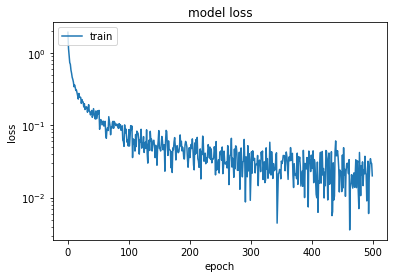

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize/NaN\3_dig5_20210723-054734.jpg NaN 5
ziffer_sortiert_resize/4\10_dig4_20210709-181251.jpg 4 NaN
ziffer_sortiert_resize/7\10_dig6_20210727-150532.jpg 7 NaN
ziffer_sortiert_resize/7\D3_2020-08-20_15-53-26.jpg 7 NaN


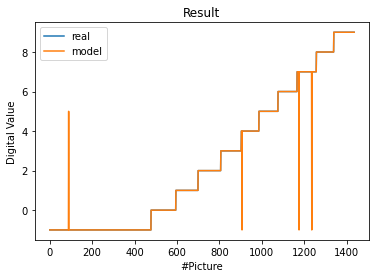

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []
only_deviation = True

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))
        if classes == -1: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp953wwfun\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpln0vtfv5\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpln0vtfv5\assets


dig1110s1q.tflite


203200

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.